# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [44]:
from sklearn import model_selection

diabetes_data = pd.read_csv("diabetes_data.csv", sep=",")

avg = np.mean(diabetes_data.iloc[:, :-1].values)
std = np.mean(diabetes_data.iloc[:, :-1].values)

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

In [45]:
diabetes_train_x = (diabetes_train_x - avg)/std
diabetes_test_x = (diabetes_test_x - avg)/std

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$F(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [47]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(diabetes_train_x, diabetes_train_y)
y_pred = model.predict(diabetes_test_x)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


and we compute the accuracy score to evaluate the model performance:

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.7447916666666666

Given that the classes balance is :

In [49]:
stats = np.unique(diabetes_test_y,return_counts=True)
for index in range(len(stats[0])):
    print("Class {0} is represented by {1:.1f}% of the data.".format(stats[0][index],
                                                                     stats[1][index]*100/np.sum(stats[1])))

Class -1 is represented by 63.0% of the data.
Class 1 is represented by 37.0% of the data.


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

The gradient of F is :

$$\nabla F(\textbf{w}) = \sum_{i=1}^n \frac{-y_i*\textbf{x}_i}{1+\exp(y_i\textbf{w}^T\textbf{x}_i)}+\lambda*\textbf{w},$$

Where $\lambda$ is the regularization of the model : it prevents the model from overfitting the data by imposing low values of the model's coefficients.

We can also write F using a decomposition $$F(\textbf{w})=\sum_{i=1}^n f_i(\textbf{w})$$ with $$f_i(\textbf{w})=log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2*n} \| \textbf{w} \|^2,$$

In [63]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, reg, lr=1e-3, batch_size=50, max_iter=500, tol=1e-6):
        self.coef_  = None
        self.tol_ = tol
        self.reg_ = reg
        self.max_iter_ = max_iter
        self.has_converged_ = False
        
        self.lr_ = lr
        self.batch_size_ = batch_size
        
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z))
    
    def set_lr(self, itr, C=2):
        self.lr_ = C / itr
        
    def evolving_lr(self, init, final, max_itr, itr):
        """
        Returns the learning rate to use at the iteration itr.

        The idea is to use a learning rate decreasing according to an inverse sigmoid function.

        Params:
            init : initial value of the learning rate
            final : final value of the learning rate
            max_itr : the number of iterations used in the process
            itr : the iteration number at which we are
        """
        alpha = 2 * (np.log((init-final)/final) - np.log(np.sqrt(init/final)-1)) / max_itr
        beta = np.log((init + final - 2*np.sqrt(init*final))/(init - final))
        return init / (1 + np.exp(alpha*itr+beta))
    
    def gradient(self, coef, batch, X, y):
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch:
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i / (1 + exp) + self.reg_*coef / n
            
        return grad# + self.reg_*coef
    
    def loss(self, coef, X, y):
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)

    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
        
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
            
            
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            #lr = max(self.lr_ / itr, 1e-3)
            #self.set_lr(itr)
            self.lr_ = self.evolving_lr(init=1e-1, final=1e-5, max_itr=self.max_iter_, itr=itr-1)
            coef_np1 = self.coef_ - self.lr_ * self.gradient(coef=self.coef_, 
                                                       X=X, y=y, 
                                                       batch=batches[itr%len(batches)])

            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            
            if abs(fn - fnp1)/fnp1 <= self.tol_:
                self.has_converged_ = True
            # Update the memory
            self.coef_ = coef_np1
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
        
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

**Warning** : The maximum value for the stepsize $\theta$ is $$(\frac{1}{4}*\sum_{i=1}^n \| \textbf{x}_i \|^2+\lambda)^{-1}$$

In [54]:
def stepsize_max(alpha):
    stepsize_max = 0
    X = (diabetes_train_x - np.mean(diabetes_train_x)) / (np.std(diabetes_train_x)+1e-3)
    for index in range(len(diabetes_train_x)):
        stepsize_max += np.matmul(np.transpose(X[index]),X[index])
    stepsize_max = 1/(stepsize_max/4 + alpha)
    
    return stepsize_max

for alpha in [10, 1, 1e-1, 1e-2, 1e-3]:
    print("The maximum value of the stepsize for alpha={0} the stepsize is : {1}".format(alpha,
                                                                                         stepsize_max(alpha)))

The maximum value of the stepsize for alpha=10 the stepsize is : 0.0008633642546397709
The maximum value of the stepsize for alpha=1 the stepsize is : 0.0008701253709205426
The maximum value of the stepsize for alpha=0.1 the stepsize is : 0.0008708073113018149
The maximum value of the stepsize for alpha=0.01 the stepsize is : 0.0008708755641345781
The maximum value of the stepsize for alpha=0.001 the stepsize is : 0.0008708823900063124


Apply to the data

In [64]:
my_model = StochasticLogisticRegression(reg=.001, lr=5e-4, batch_size=100, max_iter=5000) 
my_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
y_pred = my_model.predict(diabetes_test_x)

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.7291666666666666

Our result is close to sklearn's one -> Good Enough !

-----------

**NB :** A different evolving learning rate that we can use is the following one :

In [136]:
def evolving_lr(init, final, max_itr, itr):
    """
    Returns the learning rate to use at the iteration itr.
    
    The idea is to use a learning rate decreasing according to an inverse sigmoid function.
    
    Params:
        init : initial value of the learning rate
        final : final value of the learning rate
        max_itr : the number of iterations used in the process
        itr : the iteration number at which we are
    """
    alpha = 2 * (np.log((init-final)/final) - np.log(np.sqrt(init/final)-1)) / max_itr
    beta = np.log((init + final - 2*np.sqrt(init*final))/(init - final))
    return init / (1 + np.exp(alpha*itr+beta))

Text(0, 0.5, 'Learning rate')

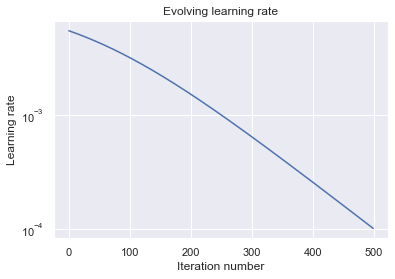

In [141]:
init = 1e-2
final = 1e-4
max_itr = 500
lr = []
for itr in range(max_itr):
    lr.append(evolving_lr(init, final, max_itr, itr))
    
plt.plot([itr for itr in range(max_itr)],lr)
plt.yscale('log')
plt.title('Evolving learning rate')
plt.xlabel('Iteration number')
plt.ylabel('Learning rate')

-----------

Let's now focus on averaging techniques. Keep in mind that two types of averagings have been seen durng the lesson :
 - Averaging the coefficients (optimize the solution)
 - Averaging the gradients (accelerated variant of the convergence)

### Averaging the coefficients

In [67]:
class StochasticAverageLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, reg, lr=1e-3, batch_size=50, max_iter=500, tol=1e-6):
        self.coef_  = None
        self.tol_ = tol
        self.reg_ = reg
        self.max_iter_ = max_iter
        self.has_converged_ = False
        
        self.lr_ = lr
        self.batch_size_ = batch_size
        
        self.grad_sum_ = 0
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z)) 
    
    def gradient(self, coef, batch, X, y, itr):
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch:
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(-y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i * exp / (1 + exp) + self.reg_*coef / n
            
        return grad
    
    def loss(self, coef, X, y):
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)

    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
        
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
            
            
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            lr = max(self.lr_ / itr**0.75, 1e-4)
            coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                       X=X, y=y, 
                                                       itr=itr, 
                                                       batch=batches[itr%len(batches)])

            # A technique of averaging the coefficients can be considered
            coef_np1 = (1 - 1/itr)*self.coef_history_[-1] + coef_np1 / itr
            
            # Let's define an early stopping
            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            if abs(fn - fnp1)/fnp1 <= self.tol_:
                self.has_converged_ = True
            
            # Update the memory
            self.coef_ = coef_np1
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
        
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

In [68]:
my_averaged_model = StochasticAverageLogisticRegression(reg=.001, lr=5e-4, batch_size=100, max_iter=5000) 
my_averaged_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
y_pred = my_averaged_model.predict(diabetes_test_x)

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.6041666666666666

###### Plot the convergence with respect to the batch size without averaging

Batch size: 1 Iterations: 691
Batch size: 10 Iterations: 375
Batch size: 25 Iterations: 919
Batch size: 50 Iterations: 1096
Batch size: 100 Iterations: 1032
Batch size: 250 Iterations: 1030


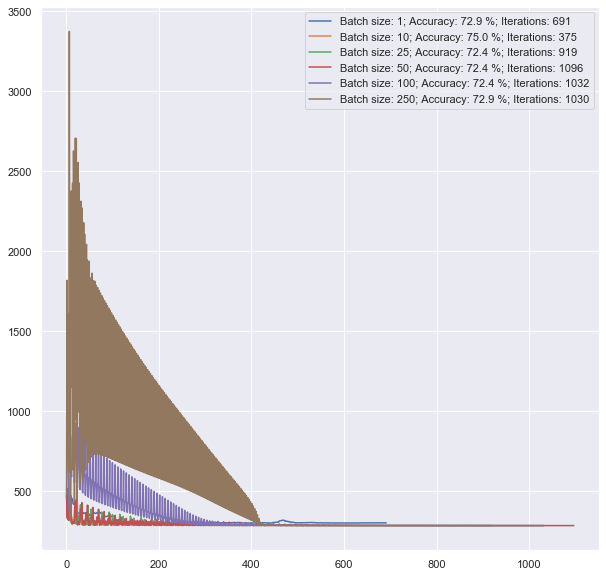

In [70]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,10))

for batch_size in [1,10,25,50,100,250]:
    my_model = StochasticLogisticRegression(reg=1, lr=0.01, batch_size=batch_size, max_iter=2000, tol=1e-6) 
    my_model.fit(diabetes_train_x, diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {}; Accuracy: {:.1f} %; Iterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y,
                                                                                             y_pred)*100,
                                                                              len(my_model.f_history_)))
    plt.legend()
    print("Batch size:", batch_size, "Iterations:", len(my_model.f_history_))
plt.show()

###### Plot the convergence with respect to the batch size with averaging

Batch size: 1 Iterations: 5
Batch size: 10 Iterations: 33
Batch size: 25 Iterations: 148
Batch size: 50 Iterations: 778
Batch size: 100 Iterations: 1660
Batch size: 250 Iterations: 1533


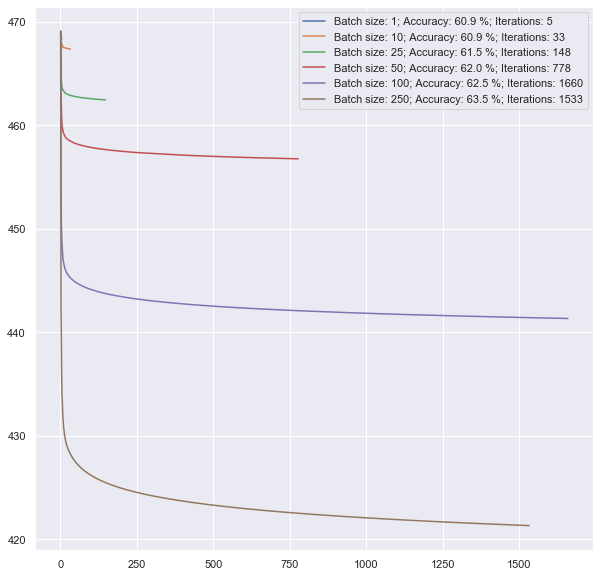

In [71]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,10))

for batch_size in [1,10,25,50,100,250]:
    my_model = StochasticAverageLogisticRegression(reg=1, lr=0.001, batch_size=batch_size, max_iter=5000, tol=1e-6) 
    my_model.fit(diabetes_train_x, diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Batch size: {}; Accuracy: {:.1f} %; Iterations: {}".format(batch_size,
                                                                              accuracy_score(diabetes_test_y, y_pred)*100,
                                                                              len(my_model.f_history_)))
    plt.legend()
    print("Batch size:", batch_size, "Iterations:", len(my_model.f_history_))
plt.show()

### Accelerated Variants

In [90]:
class AcceleratedStochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, reg, lr=1e-3, acc_type='SAG', batch_size=50, max_iter=500, tol=1e-6):
        self.coef_  = None
        self.tol_ = tol
        self.reg_ = reg
        self.max_iter_ = max_iter
        self.has_converged_ = False
        
        
        self.acc_type_ = acc_type
        self.lr_ = lr
        self.batch_size_ = batch_size
        
        self.grad_sum_ = 0
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        # logistic function
        return 1/(1+np.exp(-z)) 
    
    def gradient(self, coef, batch, X, y, itr):
        n = X.shape[0]
        grad = 0
        
        for sample_idx in batch:
            y_i = y[sample_idx]
            x_i = X[sample_idx]
            exp = np.exp(-y_i * np.matmul(np.transpose(coef), x_i))
            grad += - y_i * x_i * exp / (1 + exp) + self.reg_*coef / n
            
        return grad
    
    def loss(self, coef, X, y):
        F = 0
        for i in range(X.shape[0]):
            F += np.log(1 + np.exp(-y[i]*np.matmul(np.transpose(X[i]), coef)))

        return F + self.reg_ * 0.5 * np.matmul(np.transpose(coef), coef)

    def fit(self, X, y, start):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
        
        self.coef_ = start
        self.coef_history_.append(self.coef_)
        self.f_history_.append(self.loss(coef=self.coef_, X=X, y=y))
        
        # Batches creation
        batches = []
        phi = []
        indexes = list(range(X.shape[0]))
        while len(indexes) > 0:
            batch = []
            while len(batch) < self.batch_size_ and len(indexes) > 0:
                i = np.random.randint(low=0,high=len(indexes),size=1)[0]
                batch.append(indexes.pop(i))
            batches.append(batch)
            phi.append(self.coef_)
            
        itr = 0
        while itr < self.max_iter_ and not self.has_converged_: # critere de convergence
            itr += 1
            lr = max(self.lr_ / itr**0.75, 1e-4)
            
            grad_phi = 0
            for index in range(len(batches)):
                grad_phi += self.gradient(coef=phi[index], 
                                          X=X, y=y, itr=itr, 
                                          batch=batches[index])
            
            additional_term = lr * (self.gradient(coef=self.coef_,X=X, y=y, itr=itr, 
                                                  batch=batches[itr%len(batches)]) - 
                                    self.gradient(coef=phi[itr%len(phi)],X=X, y=y, itr=itr,
                                                  batch=batches[itr%len(batches)]))
            
            if self.acc_type_=='SAG':
                coef_np1 = self.coef_ - lr/X.shape[0] * grad_phi - additional_term/X.shape[0]
            elif self.acc_type_=='SAGA':
                coef_np1 = self.coef_ - lr/X.shape[0] * grad_phi - additional_term
            else: # Then self.acc_type_ is None
                coef_np1 = self.coef_ - lr * self.gradient(coef=self.coef_, 
                                                           X=X, y=y, itr=itr, 
                                                           batch=batches[itr%len(batches)])
            
            # Let's define an early stopping
            fn = self.f_history_[-1]
            fnp1 = self.loss(X=X, y=y, coef=coef_np1)
            if abs(fn - fnp1)/fnp1 <= self.tol_:
                self.has_converged_ = True
            
            # Update the memory
            self.coef_ = coef_np1
            phi[itr%len(phi)] = self.coef_
            self.coef_history_.append(self.coef_)
            self.f_history_.append(fnp1)
            
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        # Let's normalize X
        X = (X - np.mean(X)) / (np.std(X)+1e-3)
        
        # Let's add the intercept
        #X_aug = np.ones((X.shape[0], X.shape[1] + 1))
        #X_aug[:, 1:] = X
        #X = X_aug
                                    
        y_pred = self.logistic(np.matmul(X, self.coef_)) > 0.5
        y_pred = y_pred.astype(int) # y_pred = 0 or 1 according to the probability
        y_pred = y_pred*2 - 1 # the classes are -1 or 1
        
        return y_pred

In [94]:
my_accelerated_model = AcceleratedStochasticLogisticRegression(reg=.001, acc_type='SAGA',lr=5e-4, batch_size=100, max_iter=5000) 
my_accelerated_model.fit(diabetes_train_x, diabetes_train_y, start=np.random.rand(diabetes_train_x.shape[1]))
y_pred = my_accelerated_model.predict(diabetes_test_x)

In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.6302083333333334

Accelerated type: None Iterations: 5001
Accelerated type: SAG Iterations: 5001
Accelerated type: SAGA Iterations: 5001


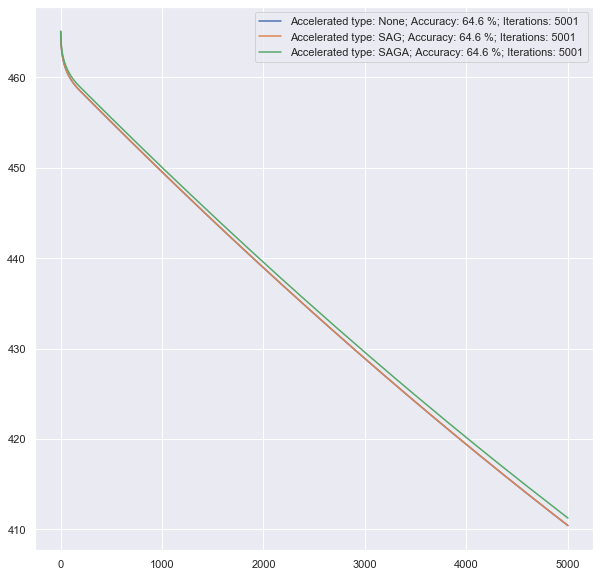

In [97]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10,10))

for acc_type in [None, 'SAG', 'SAGA']:
    my_model = AcceleratedStochasticLogisticRegression(reg=.001, acc_type=acc_type, lr=5e-3, batch_size=100, max_iter=5000, tol=1e-6) 
    my_model.fit(diabetes_train_x, diabetes_train_y, start=np.ones(shape=(diabetes_train_x.shape[1])))
    y_pred = my_model.predict(diabetes_test_x)
    plt.plot([i for i in range(1,len(my_model.f_history_)+1)], 
             my_model.f_history_, 
             label="Accelerated type: {}; Accuracy: {:.1f} %; Iterations: {}".format(acc_type,
                                                                              accuracy_score(diabetes_test_y,
                                                                                             y_pred)*100,
                                                                              len(my_model.f_history_)))
    plt.legend()
    print("Accelerated type:", acc_type, "Iterations:", len(my_model.f_history_))
plt.show()

Comment the results

Implement only one acceleration method and compare the results